In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///C:/Users/Piotrek/Documents/Inzynierka/csgo-analysis/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os
import shutil


from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, \
        f1_score, RocCurveDisplay, roc_auc_score, make_scorer
from functools import partial
from sklearn.calibration import CalibrationDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold

# Wczytanie danych

In [3]:
df = pd.read_parquet('data/states_another_mod.parquet')
df

,filename,mapName,ctBuyType,tBuyType,winningSide,matchID,roundNum,seconds,ctAlivePlayers,ctEqVal,...,de_ancient,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted
0,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
1,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.398438,5,3700,...,0,0,0,1,0,0,0,0,0,1
2,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.648438,5,3700,...,0,0,0,1,0,0,0,0,0,1
3,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,0.898438,5,3700,...,0,0,0,1,0,0,0,0,0,1
4,BLAST-Premier-Spring-Final-2022-ence-vs-big-bo...,de_mirage,Full Eco,Full Eco,CT,1,1,1.148438,5,3700,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186232,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,19.765625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186233,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.015625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186234,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.265625,1,30150,...,0,0,0,1,0,0,0,1,0,0
3186235,PGL-Major-Antwerp-2022-vitality-vs-outsiders-m...,de_mirage,Full Buy,Semi Buy,CT,333,24,20.515625,1,30150,...,0,0,0,1,0,0,0,1,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3186237 entries, 0 to 3186236
Columns: 108 entries, filename to bombsite_not_planted
dtypes: float64(17), int32(7), int64(68), object(6), uint8(10)
memory usage: 2.3+ GB


## Podział

In [5]:
df.columns.values

array(['filename', 'mapName', 'ctBuyType', 'tBuyType', 'winningSide',
       'matchID', 'roundNum', 'seconds', 'ctAlivePlayers', 'ctEqVal',
       'tAlivePlayers', 'tEqVal', 'bombsite', 'ct_hp', 't_hp', 'ct_armor',
       't_armor', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade',
       'ct_fireGrenades', 't_fireGrenades', 'ct_isBlinded', 't_isBlinded',
       'ct_hasDefuse', 't_hasBomb', 'ct_isDefusing', 't_isPlanting',
       'tScore', 'ctScore', 'ct_meanDist', 'ct_minDist', 't_meanDist',
       't_minDist', 'ct_spottedPlayers', 't_spottedPlayers',
       'ct_grouppedPlayers', 't_grouppedPlayers', 'ct_conquerMap',
       't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_Sniper

In [6]:
def select_feat(prep_df):
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_grouppedPlayers',
       'ct_meanDist', 'ct_minDist', 't_meanDist','t_minDist',
       't_grouppedPlayers', 'ct_conquerMap', 't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle', 
       'ct_secondaryWeapon_Pistol','ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'ctMeanKills',
       'tMeanKills', 'tScore', 'ctScore', 'de_ancient', 
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return prep_df[columns]

In [7]:
X = select_feat(df)
y = df['winningSideCT']
X.shape, y.shape

((3186237, 99), (3186237,))

In [8]:
y.value_counts()

1    1658611
0    1527626
Name: winningSideCT, dtype: int64

In [9]:
filtr = df.filename.str.startswith('BLAST-Premier-Spring-Final-2022')

In [10]:
X_train, X_test, y_train, y_test = X.loc[~filtr], X.loc[filtr], y[~filtr], y[filtr]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2886886, 99), (299351, 99), (2886886,), (299351,))

In [11]:
y_train.value_counts(normalize=True)

1    0.523845
0    0.476155
Name: winningSideCT, dtype: float64

In [12]:
y_test.value_counts(normalize=True)

0    0.511179
1    0.488821
Name: winningSideCT, dtype: float64

In [13]:
parameters = {
    "max_leaves": Integer(0, 70),
    "max_depth": Integer(2, 80),
    "n_estimators": Integer(100, 1300),
    "subsample": Real(0.6, 1),
}

opt = BayesSearchCV(xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0),
                    search_spaces=parameters,
                    scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True, eps=1e-7, normalize=True),
                    n_iter=50,
                    n_jobs=2, 
                    cv=StratifiedKFold(n_splits=3),
                    verbose=1,
                    random_state=42)
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=0, grow_policy=None,
                                      importance_ty...
              scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True, eps=1e-07, normalize=True),
              search_spaces={'max_depth': Integer(low=2, high=80, prior='uniform', transform='normalize'),
                             'max_leaves': Integer(low=0, high=70, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1300, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1, prior='uniform', transform='normalize')},
              verbose=1)

In [14]:
model_xgb = opt.best_estimator_
res = pd.DataFrame(opt.cv_results_)
res.sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaves,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
36,82.334657,23.068163,8.042885,0.940409,80,0,1136,1.0,"{'max_depth': 80, 'max_leaves': 0, 'n_estimato...",-1.146188,-1.184967,-1.182141,-1.171099,1.765248e-02,50
39,90.421779,26.010383,12.021769,1.737952,61,0,1300,0.77339,"{'max_depth': 61, 'max_leaves': 0, 'n_estimato...",-1.114467,-1.162694,-1.128495,-1.135218,2.025450e-02,49
11,41.109773,12.181821,5.184948,1.429156,64,0,249,0.973482,"{'max_depth': 64, 'max_leaves': 0, 'n_estimato...",-1.016581,-1.047971,-1.041784,-1.035445,1.357624e-02,48
14,41.402671,11.099491,7.457378,1.897053,66,67,1180,0.845124,"{'max_depth': 66, 'max_leaves': 67, 'n_estimat...",-0.959552,-1.045476,-1.029620,-1.011549,3.733321e-02,47
0,35.558743,8.126910,6.504124,1.694649,34,51,1219,0.72632,"{'max_depth': 34, 'max_leaves': 51, 'n_estimat...",-0.892131,-0.964410,-0.940234,-0.932258,3.004187e-02,46
8,36.543359,9.690824,6.054406,1.543182,77,49,1146,0.766328,"{'max_depth': 77, 'max_leaves': 49, 'n_estimat...",-0.855956,-0.919341,-0.908002,-0.894433,2.759856e-02,45
7,27.718243,6.958545,4.340807,0.986061,44,64,696,0.935063,"{'max_depth': 44, 'max_leaves': 64, 'n_estimat...",-0.760361,-0.821329,-0.808168,-0.796619,2.619537e-02,44
6,22.598752,5.345719,3.828522,0.807192,50,54,531,0.94973,"{'max_depth': 50, 'max_leaves': 54, 'n_estimat...",-0.665746,-0.707605,-0.706986,-0.693445,1.958818e-02,43
43,10.580924,1.862417,1.567423,0.322897,3,1,100,0.720666,"{'max_depth': 3, 'max_leaves': 1, 'n_estimator...",-0.692010,-0.692010,-0.692010,-0.692010,2.078051e-08,42
1,21.600707,5.091896,3.667062,0.863346,67,62,464,0.98049,"{'max_depth': 67, 'max_leaves': 62, 'n_estimat...",-0.661969,-0.704241,-0.697230,-0.687813,1.849786e-02,41


In [15]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


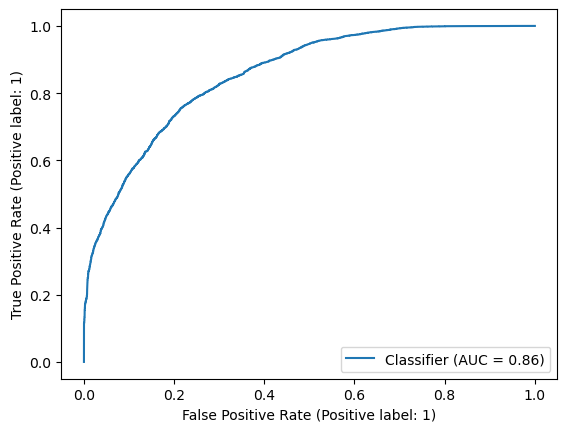

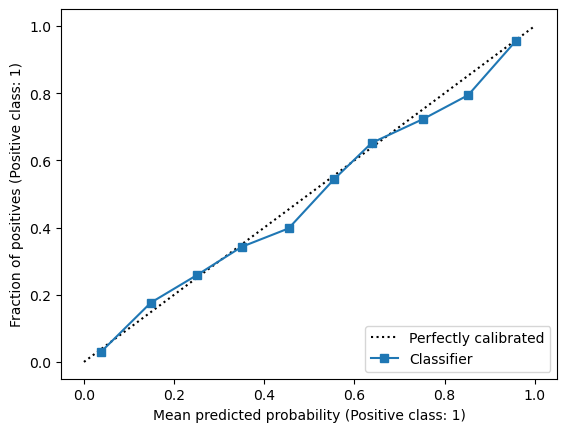

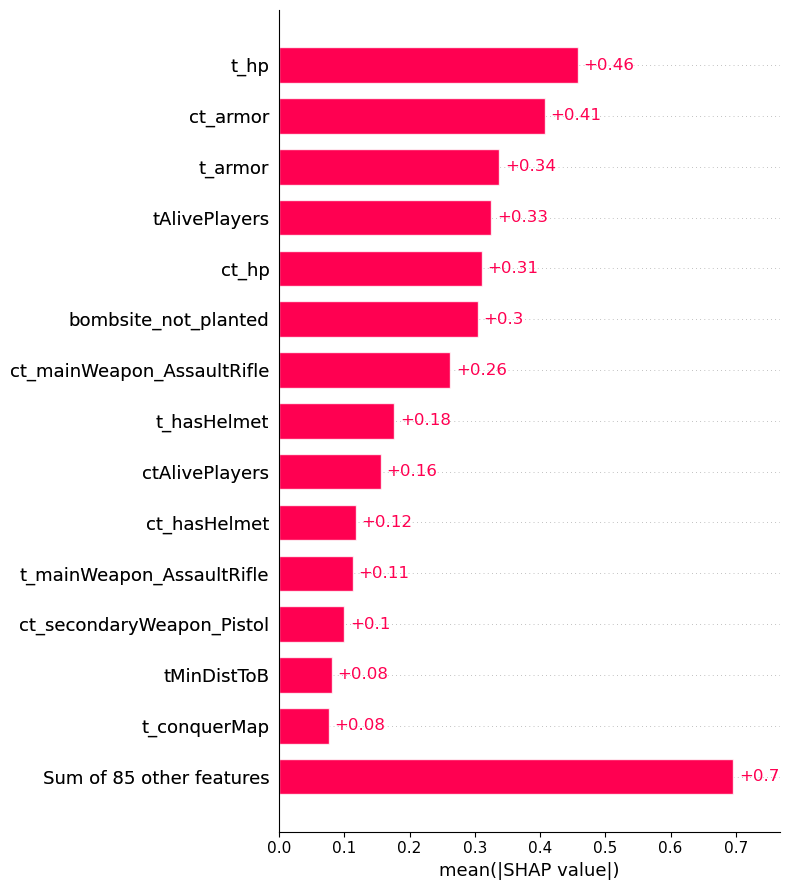

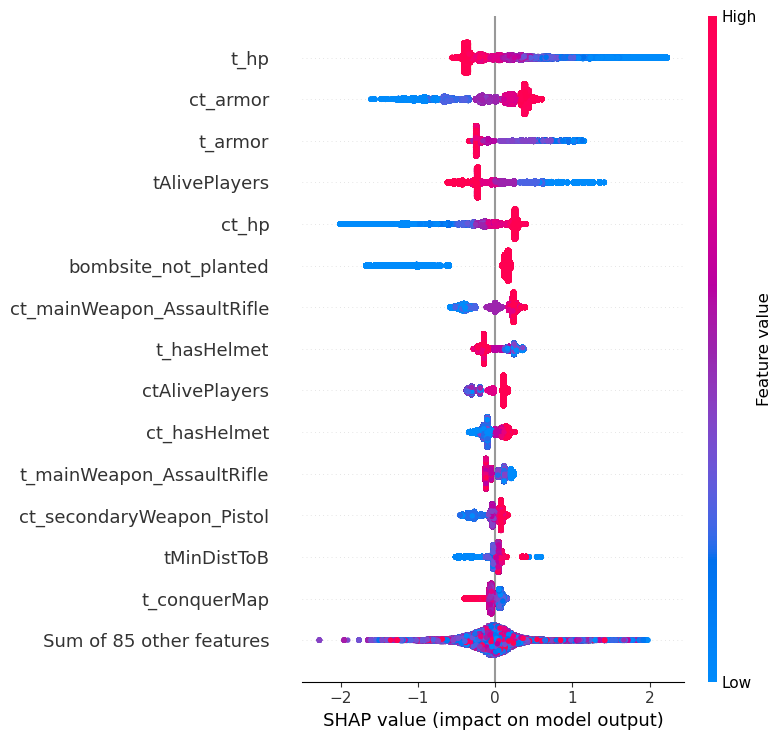

In [16]:
run_name = "XGB - All Variables"
additional_description = "XGB with Bayes Optimalization"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_params(model_xgb.get_params())
        mlflow.log_param("X_train.shape", X_train.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_params({f"{key}_space": parameters[key] for key in parameters})

        y_proba = model_xgb.predict_proba(X_test)[:, 1]
        y_true = y_test
        features_names = X_train.columns.tolist()
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
        os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
        os.makedirs('models')
        
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        with open("models/model.pkl", "wb") as f:
            pickle.dump(model_xgb, f)

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.jpg')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.jpg')
        plt.show()
        
        shap.plots.bar(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_importance.jpg')
        plt.show()
        
        shap.plots.beeswarm(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_beeplot.jpg')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")